In [30]:

from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
import torchvision.transforms.functional
import matplotlib.pyplot as plt
from torchvision.io import read_image 
from models.bisenet.build_bisenet import BiSeNet
from utils import poly_lr_scheduler
import pandas as pd
import numpy as np
def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image

In [27]:
def gta2cityscapesLabels(rgb, labels):
  #arr = np.zeros(rgb.shape[:2],dtype=np.int32) ## rgb shape: (h,w,3); arr shape: (h,w)
    rgb=rgb.permute(1,2,0)
    arr_torch=torch.ones(rgb.to(device).shape[:2],dtype=torch.int8).to(device)*255
    for label in labels:
        encoding_gta=label[1]
        encoding_cityscapes=label[2]
        arr_torch[torch.all(rgb[:,:,:].to(device) == encoding_gta, axis=-1)] = encoding_cityscapes #1 = 'id'
    return arr_torch

In [28]:
from collections import namedtuple
Label = namedtuple('Label', 
['name','id','trainId','category',
'categoryId','hasInstances',
'ignoreInEval','color',])
labels = [
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) )]

In [33]:
import os
from torchvision.utils import save_image
from PIL import Image
source_path='GTA5/GTA5/labels/'
dest_path='GTA5/GTA5/labels_correct/'
for source_annotation_filename in os.listdir(source_path):
    annotation=read_image(source_path+source_annotation_filename)
    annotation_correct=gta2cityscapesLabels(annotation,labels)
    im = Image.fromarray(annotation_correct.cpu().numpy().astype(np.uint8))
    dest_annotation_path=dest_path + source_annotation_filename
    im.save(dest_annotation_path)
    print(source_annotation_filename)


00001.png
00002.png
00003.png
00004.png
00005.png
00006.png
00007.png
00008.png
00009.png
00010.png
00011.png
00012.png
00013.png
00014.png
00015.png
00016.png
00017.png
00018.png
00019.png
00020.png
00021.png
00022.png
00023.png
00024.png
00025.png
00026.png
00027.png
00028.png
00029.png
00030.png
00031.png
00032.png
00033.png
00034.png
00035.png
00036.png
00037.png
00038.png
00039.png
00040.png
00041.png
00042.png
00043.png
00044.png
00045.png
00046.png
00047.png
00048.png
00049.png
00050.png
00051.png
00052.png
00053.png
00054.png
00055.png
00056.png
00057.png
00058.png
00059.png
00060.png
00061.png
00062.png
00063.png
00064.png
00065.png
00066.png
00067.png
00068.png
00069.png
00070.png
00071.png
00072.png
00073.png
00074.png
00075.png
00076.png
00077.png
00078.png
00079.png
00080.png
00081.png
00082.png
00083.png
00084.png
00085.png
00086.png
00087.png
00088.png
00089.png
00090.png
00091.png
00092.png
00093.png
00094.png
00095.png
00096.png
00097.png
00098.png
00099.png
00100.png


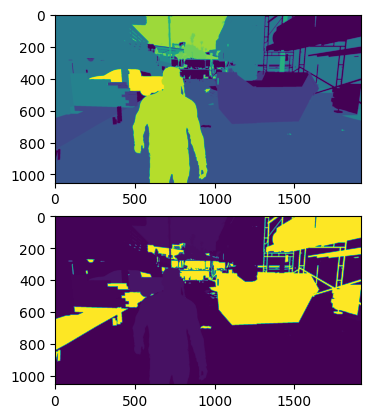

tensor([27], dtype=torch.uint8)
tensor([14], dtype=torch.uint8)


In [43]:
from torchvision.io import read_image 
img=read_image('GTA5/GTA5/labels/00001.png').permute(1,2,0)
img1=read_image('GTA5/GTA5/labels_correct/00001.png').permute(1,2,0)

source_path='datasets/GTA5/GTA5/labels/'
dest_path='datasets/GTA5/GTA5/labels_correct/'
fig, axes = plt.subplots(2, 1)
axes[0].imshow(img)
axes[1].imshow(img1)
plt.show()
print(img[400][500])
print(img1[400][500])